In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivangmishra1257","key":"5ccd3f3150319916d7328ed4780f9e7b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammadardiputra/potato-leaf-disease-dataset
License(s): unknown
  0% 0.00/25.2M [00:00<?, ?B/s]
100% 25.2M/25.2M [00:00<00:00, 831MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("potato-leaf-disease-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("potato_leaf_data")

In [ ]:
import os

base_dir = "potato_leaf_data"

for folder in os.listdir(base_dir):
    print(folder)

Potato


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
IMAGE_SIZE = 255
BATCH_SIZE = 32
CHANNEL = 3

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "potato_leaf_data/Potato/Train",
    seed = 136,
    shuffle = True ,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 900 files belonging to 3 classes.


In [ ]:
len(dataset)

29

In [ ]:
class_names = dataset.class_names

In [ ]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for batch_size, (image_batch, label_batch) in enumerate(dataset):
    print(image_batch.shape)
    print(label_batch.numpy())
    break

(32, 255, 255, 3)
[1 0 1 2 2 1 2 1 1 1 1 1 0 2 0 2 0 0 2 0 1 1 0 2 2 2 1 1 1 0 0 1]


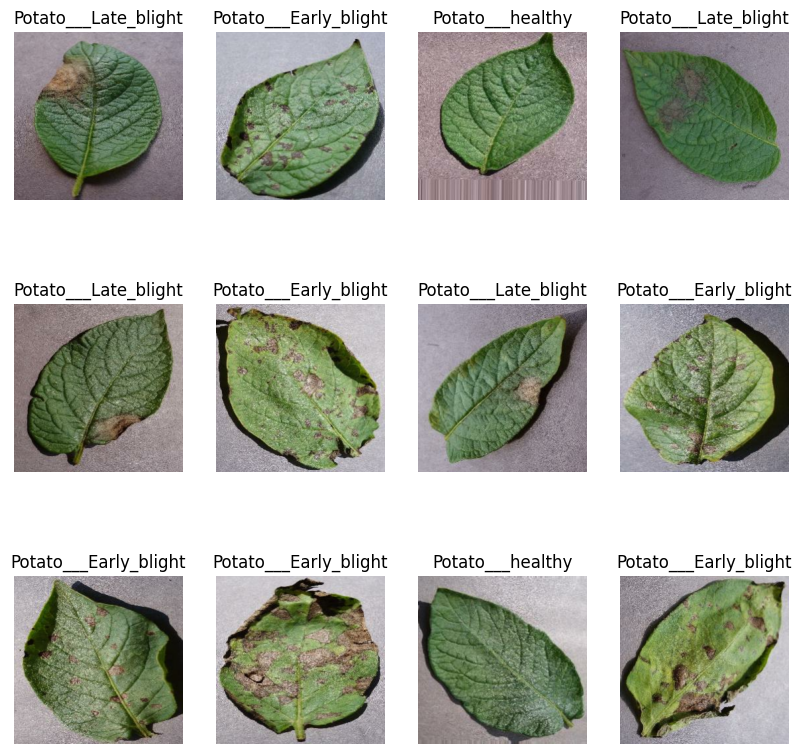

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

29

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "potato_leaf_data/Potato/Train",
    seed=136,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "potato_leaf_data/Potato/Valid",
    seed=136,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "potato_leaf_data/Potato/Test",
    seed=136,
    shuffle=False,  # Keep test set in order
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
len(train_ds) , len(test_ds) , len(val_ds)

(29, 10, 10)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Rescaling, Resizing

resize_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0 / 255)
])


In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    RandomRotation(0.2),                    # Randomly rotate images
    RandomZoom(0.1),                        # Randomly zoom in
])

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=AUTOTUNE)

# ***MODEL***

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3
model = Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.3637 - loss: 1.0995 - val_accuracy: 0.3333 - val_loss: 1.0929
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.3483 - loss: 1.0920 - val_accuracy: 0.3433 - val_loss: 1.0403
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.4704 - loss: 0.9971 - val_accuracy: 0.7700 - val_loss: 0.5043
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.7264 - loss: 0.6036 - val_accuracy: 0.8267 - val_loss: 0.3436
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.8369 - loss: 0.4027 - val_accuracy: 0.8667 - val_loss: 0.3320
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.8581 - loss: 0.3671 - val_accuracy: 0.8767 - val_loss: 0.3057
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.8771 - loss: 0.3183 - val_accuracy: 0.8533 - val_loss: 0.3344
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.8265 - loss: 0.4248 - val_accuracy: 0.8333 - v

In [ ]:
model.save('model.h5')

In [ ]:
model = tf.keras.models.load_model('model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Actual Label- Potato___Early_blight
Predicted Label- Potato___Early_blight


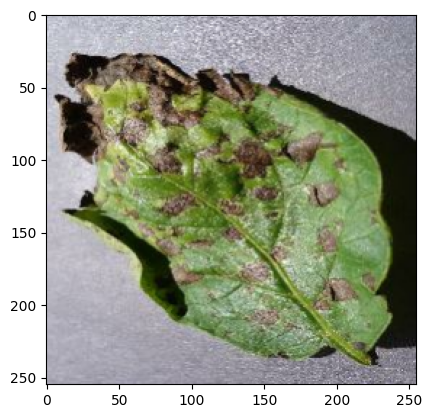

In [ ]:
for img , label in test_ds.take(1):
  first_img = img[0].numpy().astype('uint8')
  first_label = label[0].numpy()

  predict_img = model.predict(img)

  plt.imshow(first_img)
  print("Actual Label-" , class_names[first_label])
  print("Predicted Label-" , class_names[np.argmax(predict_img[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Actual Label: Potato___Late_blight
Predicted Label: Potato___Early_blight
Confidence: 98.56 %


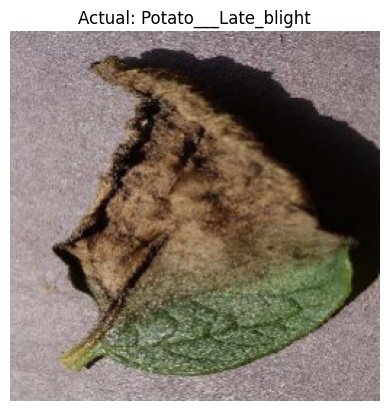

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Load your model (if not already loaded)
model = tf.keras.models.load_model('model.h5')

# Prediction function
def predict(model , img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array , 0)
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    return predicted_class , confidence

# Collect all test images and labels into lists
all_images = []
all_labels = []

for img_batch, label_batch in test_ds:
    for img, label in zip(img_batch, label_batch):
        all_images.append(img)
        all_labels.append(label)

# Pick a random image index
idx = random.randint(0, len(all_images) - 1)
random_img = all_images[idx].numpy().astype("uint8")
random_label = all_labels[idx].numpy()

# Display the random image
plt.imshow(random_img)
plt.axis("off")
plt.title(f"Actual: {class_names[random_label]}")

# Predict the random image
predicted_class, confidence = predict(model, random_img)
print("Actual Label:", class_names[random_label])
print("Predicted Label:", predicted_class)
print("Confidence:", confidence, "%")


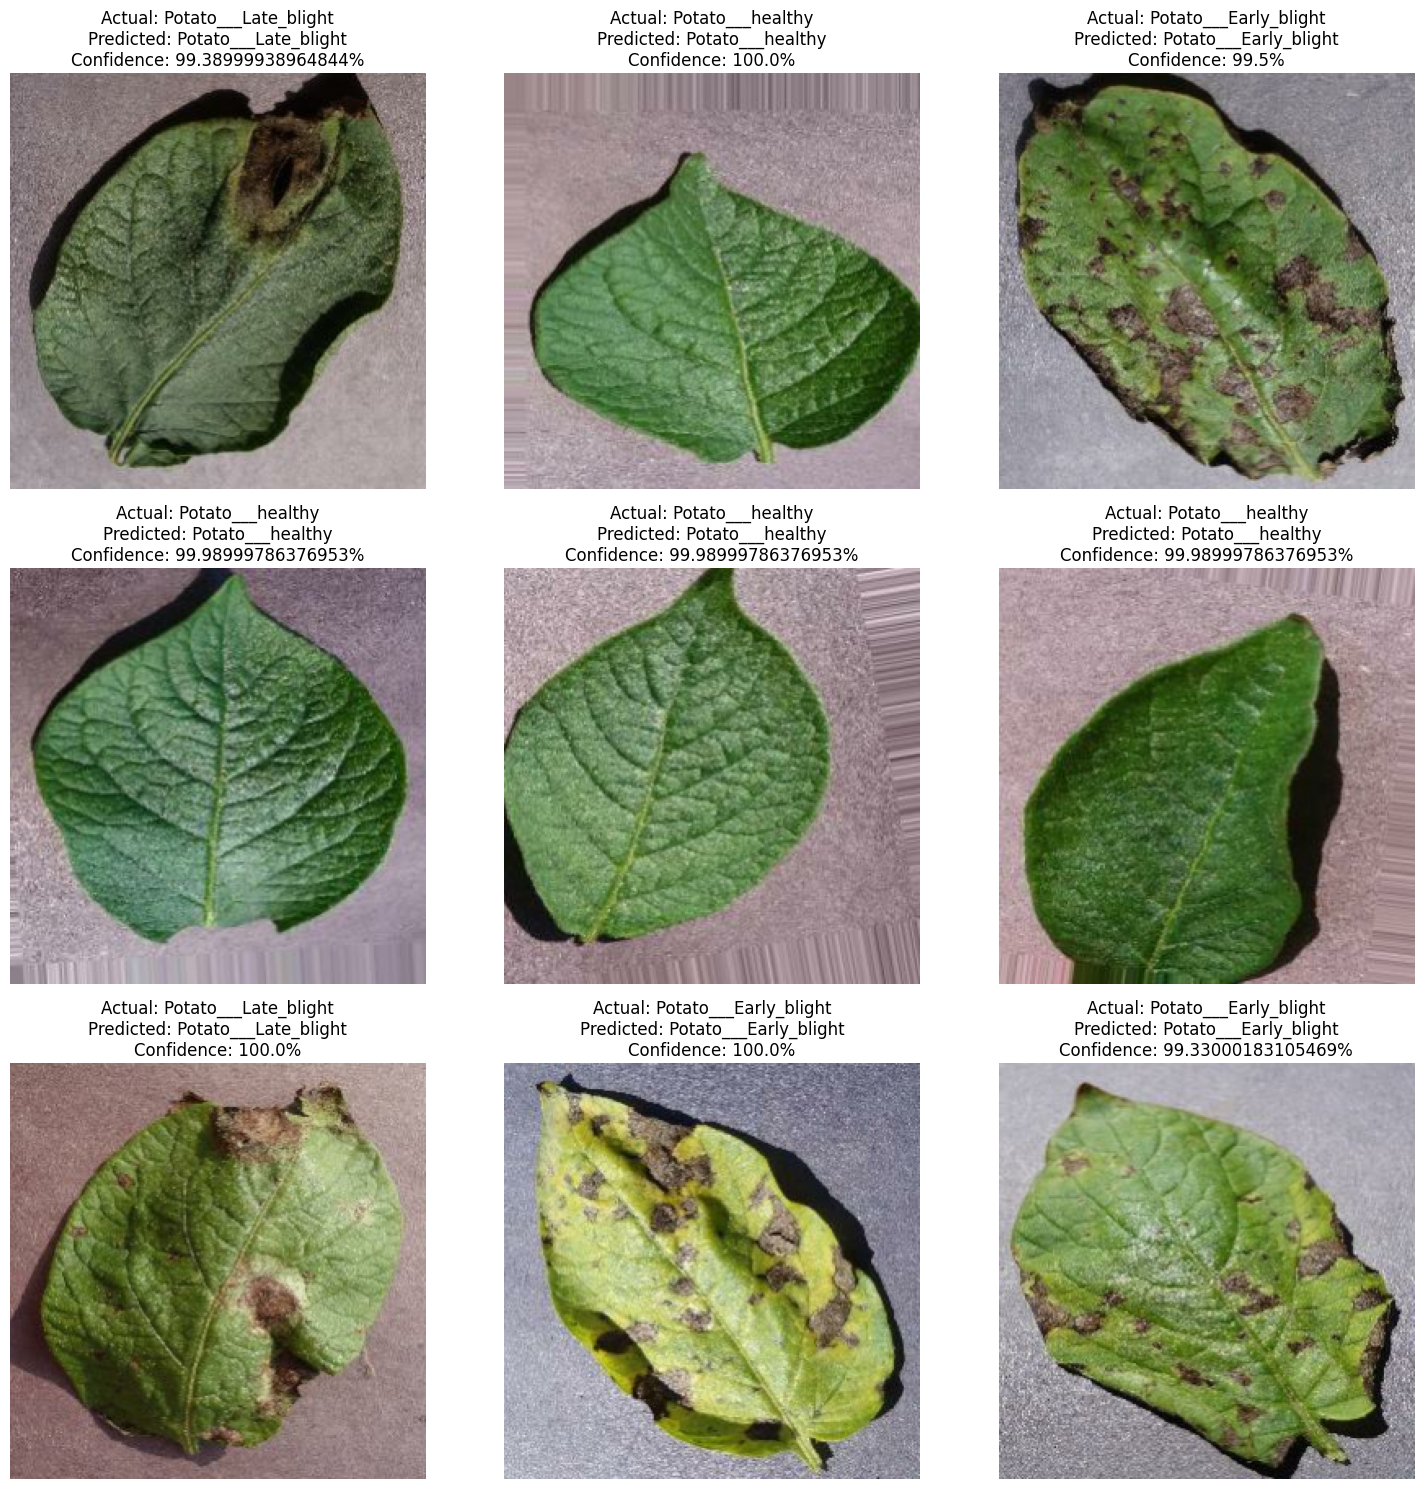

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Collect all test images and labels
all_images = []
all_labels = []

for img_batch, label_batch in test_ds:
    for img, label in zip(img_batch, label_batch):
        all_images.append(img)
        all_labels.append(label)

# Shuffle indices to pick 9 random images
random_indices = random.sample(range(len(all_images)), 9)

# Prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array , 0)
    prediction = model.predict(img_array, verbose=0)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    return predicted_class , confidence

# Plot 9 random test images with prediction
plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    image = all_images[idx].numpy().astype("uint8")
    label = all_labels[idx].numpy()

    plt.imshow(image)
    predicted_class, confidence = predict(model, image)
    actual_class = class_names[label]

    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
tf.__version__

'2.18.0'